In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel, ViTModel
from torchvision import transforms
from PIL import Image

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create a directory if it doesn't exist
directory = '/kaggle/working/images'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla P100-PCIE-16GB


## Loading and visualising the preprocessed VQA Test Dataset

In [4]:
train_df = pd.read_csv("/kaggle/input/vqa-csv/vqa_train.csv")
train_df

question    answer  \
0                                     where is the baby?   counter   
1             what color is the shade in the background?     multi   
2                       why is the middle man crouching?   catcher   
3                          what fruit is in the picture?     apple   
4      does that geometric box have tourist information?       yes   
...                                                  ...       ...   
74109  was this picture taken before or after the bal...    before   
74110                         what is the woman holding?  umbrella   
74111  what numbers are on the bottom of the front of...        72   
74112              which foot is the tether attached to?      left   
74113                    are the dogs going for a drive?       yes   

                                                  images  label  
0      /kaggle/input/vqa-images/train2014/COCO_train2...   1589  
1      /kaggle/input/vqa-images/train2014/COCO_train2...   3148  
2      /kaggle/input/vqa-images/train2014/COCO_train2...   1319  
3      /kaggle/input/vqa-images/train2014/COCO_train2...    761  
4      /kaggle/input/vqa-images/train2014/COCO_train2...   5073  
...                                                  ...    ...  
74109  /kaggle/input/vqa-images/train2014/COCO_train2...    958  
74110  /kaggle/input/vqa-images/train2014/COCO_train2...   4765  
74111  /kaggle/input/vqa-images/train2014/COCO_train2...    561  
74112  /kaggle/input/vqa-images/train2014/COCO_train2...   2796  
74113  /kaggle/input/vqa-images/train2014/COCO_train2...   5073  

[74114 rows x 4 columns]

In [5]:
val_df = pd.read_csv("/kaggle/input/vqa-csv/vqa_val.csv")
val_df

question    answer  \
0                    is the man wearing tennis clothes?        no   
1                            which boy was just at bat?  crawford   
2                            where is the cat sleeping?    laptop   
3                                is there toilet paper?       yes   
4                        are there fish in the picture?       yes   
...                                                 ...       ...   
10289                        what shape are the clouds?     round   
10290  is there snow on the ground under the stop sign?       yes   
10291                           what color is the ball?       red   
10292                 is the woman going to eat it all?       yes   
10293                         where is the man sitting?     bench   

                                                  images  label  
0      /kaggle/input/vqa-images/train2014/COCO_train2...   3229  
1      /kaggle/input/vqa-images/train2014/COCO_train2...   1613  
2      /kaggle/input/vqa-images/train2014/COCO_train2...   2764  
3      /kaggle/input/vqa-images/train2014/COCO_train2...   5073  
4      /kaggle/input/vqa-images/train2014/COCO_train2...   5073  
...                                                  ...    ...  
10289  /kaggle/input/vqa-images/train2014/COCO_train2...   3878  
10290  /kaggle/input/vqa-images/train2014/COCO_train2...   5073  
10291  /kaggle/input/vqa-images/train2014/COCO_train2...   3780  
10292  /kaggle/input/vqa-images/train2014/COCO_train2...   5073  
10293  /kaggle/input/vqa-images/train2014/COCO_train2...    970  

[10294 rows x 4 columns]

In [6]:
test_df = pd.read_csv("/kaggle/input/vqa-csv/vqa_test.csv")
test_df

question    answer  \
0        what is strapped to the bike?  umbrella   
1               where is the location?       zoo   
2       what hairstyle is she wearing?  ponytail   
3                       how many beds?         1   
4                  are the dogs twins?        no   
...                                ...       ...   
18524           what are they playing?    tennis   
18525     what is painted on the bowl?   flowers   
18526      is this man wearing shorts?        no   
18527           are these all toilets?        no   
18528  are these people in the desert?        no   

                                                  images  label  
0      /kaggle/input/vqa-images/train2014/COCO_train2...   4765  
1      /kaggle/input/vqa-images/train2014/COCO_train2...   5095  
2      /kaggle/input/vqa-images/train2014/COCO_train2...   3601  
3      /kaggle/input/vqa-images/train2014/COCO_train2...     40  
4      /kaggle/input/vqa-images/train2014/COCO_train2...   3229  
...                                                  ...    ...  
18524  /kaggle/input/vqa-images/train2014/COCO_train2...   4547  
18525  /kaggle/input/vqa-images/train2014/COCO_train2...   2123  
18526  /kaggle/input/vqa-images/train2014/COCO_train2...   3229  
18527  /kaggle/input/vqa-images/train2014/COCO_train2...   3229  
18528  /kaggle/input/vqa-images/train2014/COCO_train2...   3229  

[18529 rows x 4 columns]

In [7]:
# Load LabelEncoder
le = joblib.load('/kaggle/input/vqa-models/label_encoder.pkl')

In [8]:
test1 = le.inverse_transform([15])[0]
print(test1)

test2 = le.inverse_transform([35])[0]
print(test2)

005
07


In [9]:
combined_labels = pd.concat([train_df['label'], val_df['label'], test_df['label']], axis=0)
len(set(combined_labels))

5099

## Preparing the Visual Question answering Dataset

In [10]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, questions, answers, transform=None, tokenizer=None):
        self.image_paths = image_paths
        self.questions = questions
        self.answers = answers
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        question = self.questions[idx]
        inputs = self.tokenizer(question, return_tensors='pt', padding='max_length', max_length=16, truncation=True)
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}

        answer = torch.tensor(self.answers[idx], dtype=torch.long)

        return image, inputs, answer

# Inference of model fine-tuned without the help of LoRA

## Defining the Multimodal VQA Model Architecture

In [11]:
# Define the model
class VQAModel(nn.Module):
    def __init__(self, num_answers):
        super(VQAModel, self).__init__()
        self.vision_transformer = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.text_transformer = BertModel.from_pretrained('bert-base-uncased')
        
        self.fc1 = nn.Linear(self.vision_transformer.config.hidden_size, 512)
        self.fc2 = nn.Linear(self.text_transformer.config.hidden_size, 512)
        self.fc3 = nn.Linear(512 * 2, num_answers)

    def forward(self, image, text):
        vision_outputs = self.vision_transformer(pixel_values=image)
        text_outputs = self.text_transformer(**text)

        vision_feats = self.fc1(vision_outputs.last_hidden_state[:, 0, :])
        text_feats = self.fc2(text_outputs.last_hidden_state[:, 0, :])

        combined_feats = torch.cat((vision_feats, text_feats), dim=1)
        logits = self.fc3(combined_feats)

        return logits

In [12]:
# Initialize model, loss, optimizer
num_answers = len(set(combined_labels)) # Number of unique answers
print(num_answers)

# Initialize the model
model = VQAModel(num_answers)
model.load_state_dict(torch.load('/kaggle/input/vqa-models/best_model.pth', map_location=torch.device('cpu')))

5099


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<All keys matched successfully>

In [13]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load validation data
test_image_paths = test_df.images.to_list()  # List of image file paths
test_questions = test_df.question.to_list()  # List of questions
test_answers = test_df.label.to_list()  # List of answer indices

test_dataset = VQADataset(test_image_paths, test_questions, test_answers, transform=transform, tokenizer=tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
# Move model to GPU if available
model.to(device)

VQAModel(
  (vision_transformer): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768

In [15]:
all_labels = []
all_preds = []

model.eval()

i=0
with torch.no_grad():
    for images, texts, labels in test_loader:
        i=i+1
        if i%100==0:
            print(i)
        images, labels = images.to(device), labels.to(device)
        texts = {key: val.to(device) for key, val in texts.items()}
        
        outputs = model(images, texts)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

100
200
300
400
500


In [16]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.2938
F1 Score: 0.2388
Precision: 0.2307
Recall: 0.2938


## Visualising answers predicted using model fine-tuned without the help of LoRA

In [57]:
def showExample(id=None):
    df = test_df
    if id == None:
        id = np.random.randint(len(df))
    image = Image.open(df['images'][id])
    display(image)

    print("Question:\t", df['question'][id])
    print("Answer:\t\t", df['answer'][id], "(Label: {0})".format(df['label'][id]))
    print("Id:\t\t", id)
    print("Predicted Answer:", le.inverse_transform([all_preds[id]])[0] )
    print("Predicted label:", all_preds[id])

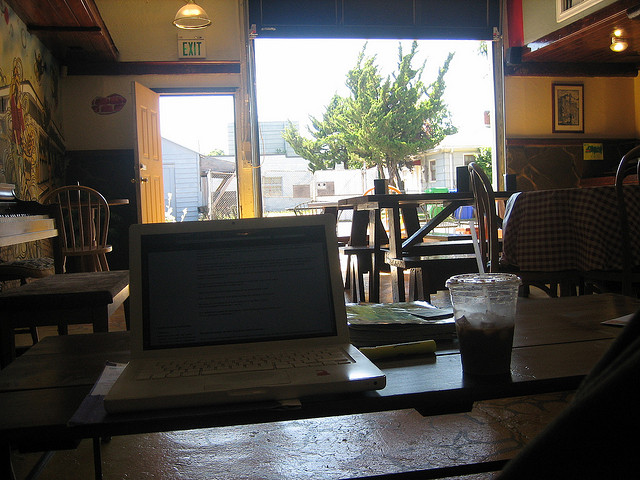

Question:	 what cup is on the table?
Answer:		 soda (Label: 4232)
Id:		 844
Predicted Answer: water
Predicted label: 4912


In [58]:
showExample()

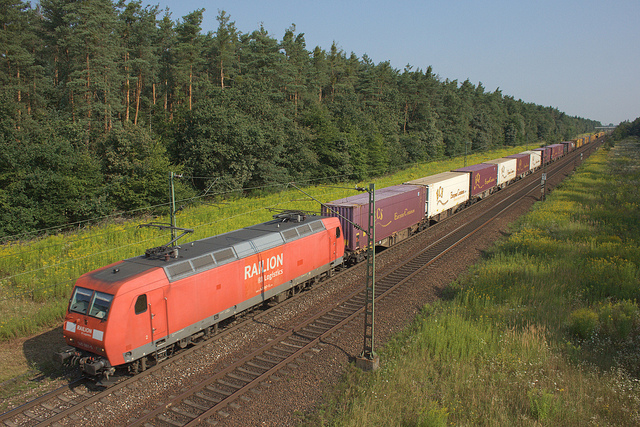

Question:	 is the train passing through a snowy area?
Answer:		 no (Label: 3229)
Id:		 16039
Predicted Answer: no
Predicted label: 3229


In [59]:
showExample()

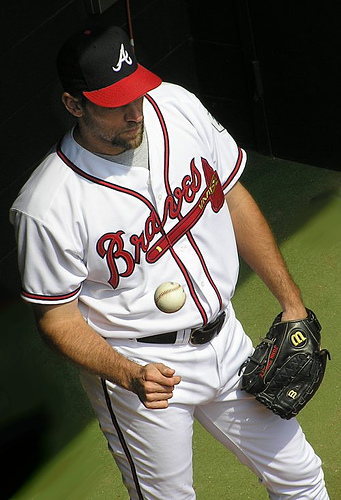

Question:	 do you like the man is cap?
Answer:		 yes (Label: 5073)
Id:		 12961
Predicted Answer: yes
Predicted label: 5073


In [60]:
showExample()

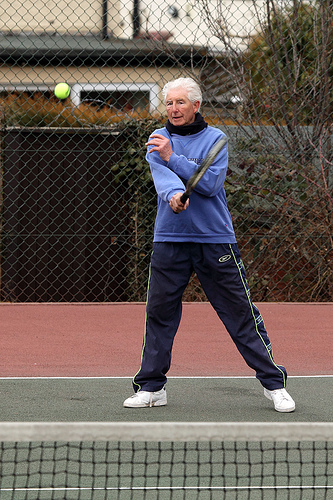

Question:	 did the man hit the ball?
Answer:		 yes (Label: 5073)
Id:		 1621
Predicted Answer: yes
Predicted label: 5073


In [61]:
showExample()

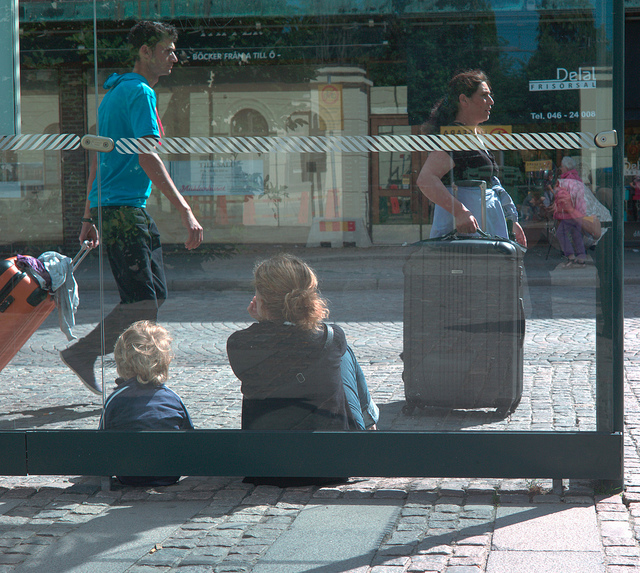

Question:	 what are they waiting on?
Answer:		 bus (Label: 1200)
Id:		 5216
Predicted Answer: grass
Predicted label: 2308


In [62]:
showExample()

# Inference of model fine-tuned with the help of LoRA

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LoRA(nn.Module):
    def __init__(self, original_layer, rank, lora_alpha=32, lora_dropout=0.1):
        super(LoRA, self).__init__()
        self.original_layer = original_layer
        self.rank = rank
        self.lora_alpha = lora_alpha
        self.lora_dropout = nn.Dropout(lora_dropout)

        in_features = original_layer.in_features
        out_features = original_layer.out_features

        self.lora_A = nn.Parameter(torch.randn(in_features, rank))
        self.lora_B = nn.Parameter(torch.randn(rank, out_features))

        # Initialize LoRA parameters
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        lora_out = self.lora_dropout(x) @ self.lora_A @ self.lora_B * self.lora_alpha
        return self.original_layer(x) + lora_out

In [24]:
def set_nested_attr(obj, attr, value):
    attrs = attr.split('.')
    for attr in attrs[:-1]:
        obj = getattr(obj, attr)
    setattr(obj, attrs[-1], value)


def apply_lora(model, rank):
    # Collect layers to be replaced
    modules_to_replace = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            modules_to_replace.append((name, module))
    
    # Replace layers
    for name, module in modules_to_replace:
        set_nested_attr(model, name, LoRA(module, rank))
    
    return model

## Defining the Multimodal VQA Model Architecture 


In [25]:
# Define the model
class VQAModel_lora(nn.Module):
    def __init__(self, num_answers, lora_rank=8):
        super(VQAModel_lora, self).__init__()
        self.vision_transformer = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.text_transformer = BertModel.from_pretrained('bert-base-uncased')
        
        # Apply LoRA to both transformers
        self.vision_transformer = apply_lora(self.vision_transformer, lora_rank)
        self.text_transformer = apply_lora(self.text_transformer, lora_rank)
        
        self.fc1 = nn.Linear(self.vision_transformer.config.hidden_size, 512)
        self.fc2 = nn.Linear(self.text_transformer.config.hidden_size, 512)
        self.fc3 = nn.Linear(512 * 2, num_answers)

    def forward(self, image, text):
        vision_outputs = self.vision_transformer(pixel_values=image)
        text_outputs = self.text_transformer(**text)

        vision_feats = self.fc1(vision_outputs.last_hidden_state[:, 0, :])
        text_feats = self.fc2(text_outputs.last_hidden_state[:, 0, :])

        combined_feats = torch.cat((vision_feats, text_feats), dim=1)
        logits = self.fc3(combined_feats)

        return logits

In [26]:
# Initialize model, loss, optimizer
num_answers = len(set(combined_labels)) # Number of unique answers
print(num_answers)

# Initialize the model
model_lora = VQAModel_lora(num_answers, lora_rank=16)
model_lora.load_state_dict(torch.load('/kaggle/input/vqa-models/best_model_lora.pth'))

5099


<All keys matched successfully>

In [27]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load validation data
test_image_paths = test_df.images.to_list()  # List of image file paths
test_questions = test_df.question.to_list()  # List of questions
test_answers = test_df.label.to_list()  # List of answer indices

test_dataset = VQADataset(test_image_paths, test_questions, test_answers, transform=transform, tokenizer=tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
model_lora.to(device)

VQAModel_lora(
  (vision_transformer): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): LoRA(
                (original_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): Dropout(p=0.1, inplace=False)
              )
              (key): LoRA(
                (original_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): Dropout(p=0.1, inplace=False)
              )
              (value): LoRA(
                (original_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): Dropout(p=0.1, inplace=False)
      

In [29]:
all_labels_lora = []
all_preds_lora = []

model_lora.eval()

i=0
with torch.no_grad():
    for images, texts, labels in test_loader:
        i=i+1
        if i%100==0:
            print(i)
        images, labels = images.to(device), labels.to(device)
        texts = {key: val.to(device) for key, val in texts.items()}
        
        outputs = model_lora(images, texts)
        _, preds_lora = torch.max(outputs, 1)
        
        all_labels_lora.extend(labels.cpu().numpy())
        all_preds_lora.extend(preds_lora.cpu().numpy())      

100
200
300
400
500


In [30]:
# Calculate metrics
accuracy_lora = accuracy_score(all_labels_lora, all_preds_lora)
f1_lora = f1_score(all_labels_lora, all_preds_lora, average='weighted')
precision_lora = precision_score(all_labels_lora, all_preds_lora, average='weighted')
recall_lora = recall_score(all_labels_lora, all_preds_lora, average='weighted')

print(f'Accuracy: {accuracy_lora:.4f}')
print(f'F1 Score: {f1_lora:.4f}')
print(f'Precision: {precision_lora:.4f}')
print(f'Recall: {recall_lora:.4f}')

Accuracy: 0.2695
F1 Score: 0.2018
Precision: 0.1858
Recall: 0.2695


## Visualising answers predicted using model fine-tuned with the help of LoRA

In [39]:
def ShowExample(id=None):
    df = test_df
    if id == None:
        id = np.random.randint(len(df))
    image = Image.open(df['images'][id])
    display(image)

    print("Question:\t", df['question'][id])
    print("Answer:\t\t", df['answer'][id], "(Label: {0})".format(df['label'][id]))
    print("Id:\t\t", id)
    print("Predicted Answer:", le.inverse_transform([all_preds_lora[id]])[0] )
    print("Predicted label:", all_preds_lora[id])

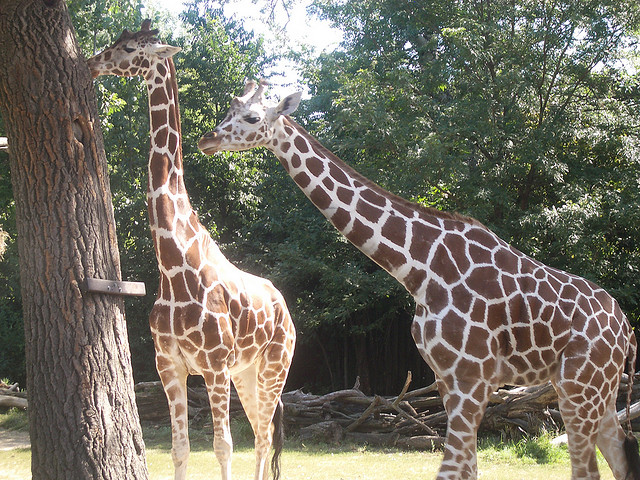

Question:	 are the giraffes looking at each other?
Answer:		 no (Label: 3229)
Id:		 11556
Predicted Answer: yes
Predicted label: 5073


In [40]:
ShowExample()

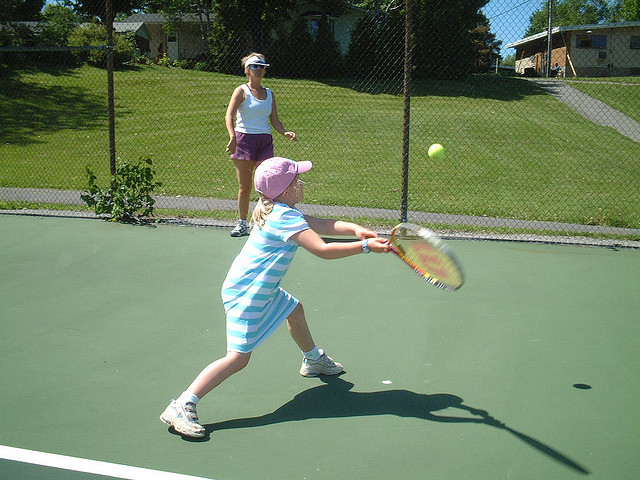

Question:	 how many hands is on the racket?
Answer:		 2 (Label: 239)
Id:		 11938
Predicted Answer: 1
Predicted label: 40


In [41]:
ShowExample()

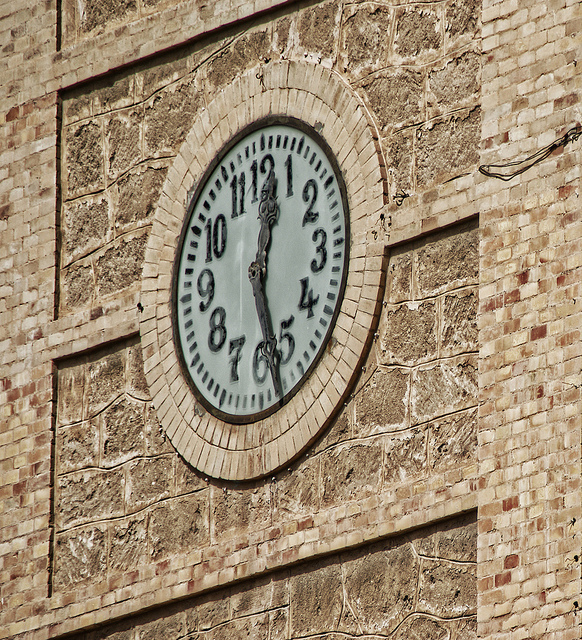

Question:	 does this wall look like brick?
Answer:		 yes (Label: 5073)
Id:		 18167
Predicted Answer: yes
Predicted label: 5073


In [42]:
ShowExample()

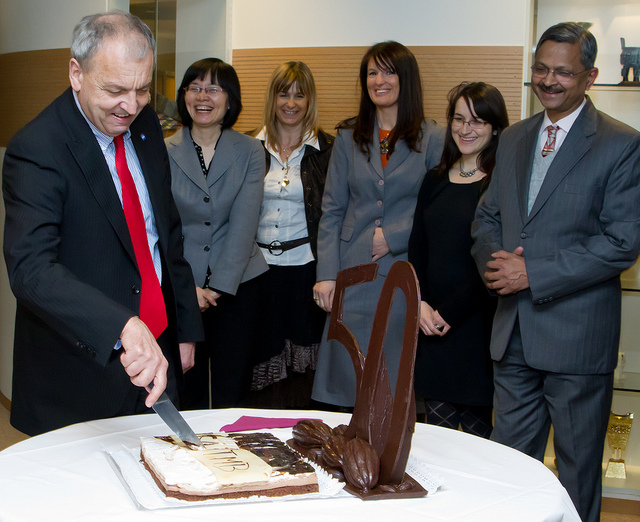

Question:	 is this item attached to the desk?
Answer:		 no (Label: 3229)
Id:		 3422
Predicted Answer: yes
Predicted label: 5073


In [43]:
ShowExample()

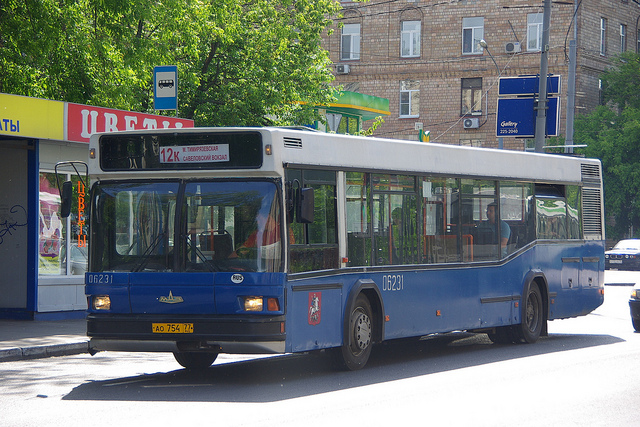

Question:	 what says in front of the bus?
Answer:		 06231 (Label: 34)
Id:		 2664
Predicted Answer: 1
Predicted label: 40


In [44]:
ShowExample()

# Visualising the performance metrics

## Comparing Time Taken for Training(TTT) 

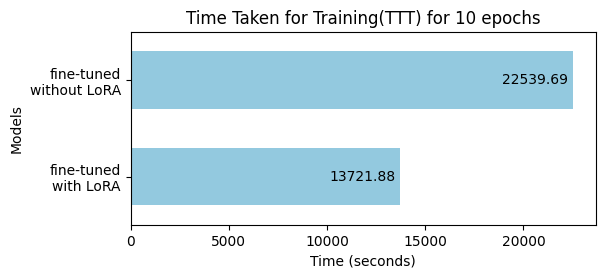

In [37]:
data = {
    'Categories': ['fine-tuned\nwithout LoRA', 'fine-tuned\nwith LoRA'],
    'Time': [22539.69, 13721.88]
}
df = pd.DataFrame(data)

# Set the plot size
plt.figure(figsize=(6, 2.5))

# Create horizontal bar plot
sns.barplot(x='Time', y='Categories', data=df, color='skyblue', width=0.6)

# Add values over each bar
for i, value in enumerate(df['Time']):
    plt.text(value - 250, i, str(value), ha='right', va='center')

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Models')
plt.title('Time Taken for Training(TTT) for 10 epochs')

# Save the plot to a file
plt.savefig('images/Time_taken_for_training.png')

# Show plot
plt.show()

## Comparing the Accuracy, F1 score , Presision and Recall

In [45]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

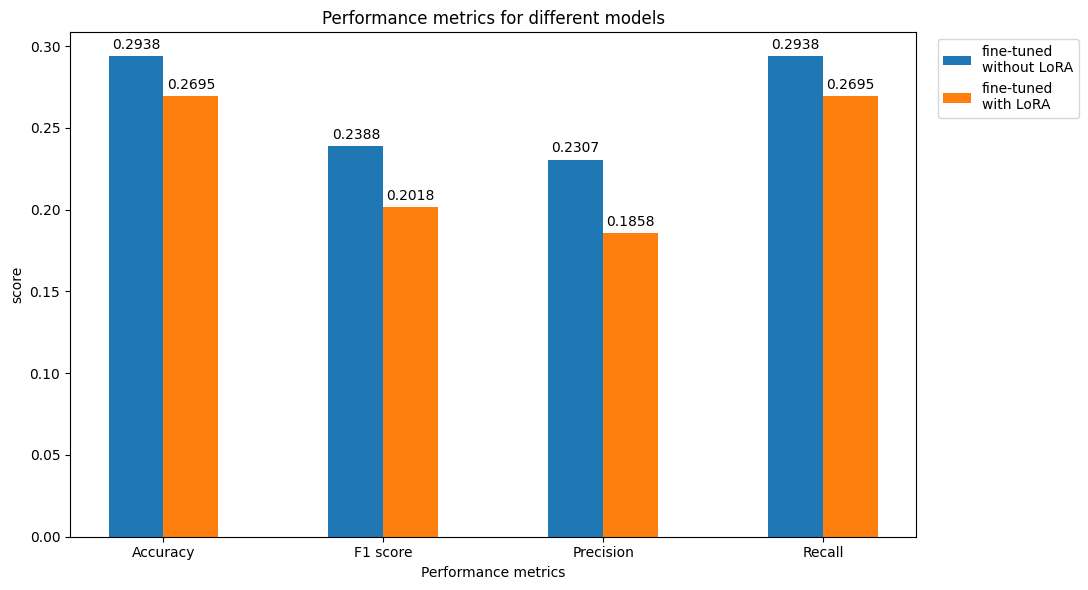

In [56]:
categories = ['Accuracy', 'F1 score', 'Precision', 'Recall']

model_without_lora = [accuracy, f1, precision, recall]
model_with_lora = [accuracy_lora, f1_lora, precision_lora, recall_lora]

model_without_lora = [round(elem, 4) for elem in model_without_lora ]
model_with_lora = [round(elem, 4) for elem in model_with_lora ]

# Set the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.arange(len(categories))

# Plotting the bars
fig, ax = plt.subplots(figsize=(11, 6))
rects1 = plt.bar(x - bar_width/2, model_without_lora, width=bar_width, label='fine-tuned\nwithout LoRA')
rects2 = plt.bar(x + bar_width/2, model_with_lora, width=bar_width, label='fine-tuned\nwith LoRA')

# Customize plot
plt.xlabel('Performance metrics')
plt.ylabel('score')
plt.title('Performance metrics for different models')
plt.xticks(x, categories, ha='center')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

autolabel(rects1)
autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()

# Save the plot to a file
plt.savefig('images/performance_metrics.png')

# Show plot
plt.show()

## Training and Validation accuracy during training of the model fine-tuned without the help of LoRA

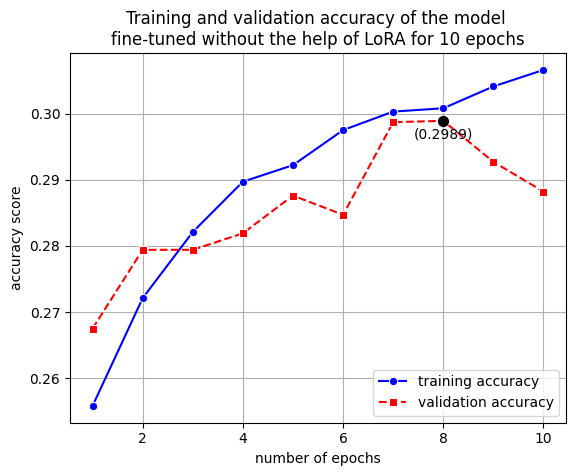

In [63]:
temp_list = list(range(1,11))
data = {
        'X'                    : temp_list,
        'training_accuracy'    : [0.2558, 0.2721, 0.2821, 0.2897, 0.2922, 0.2975, 0.3003, 0.3008, 0.3041, 0.3066],
        'validation_accuracy'  : [0.2675, 0.2794, 0.2794, 0.2819, 0.2876, 0.2847, 0.2987, 0.2989, 0.2927, 0.2882]
}

df = pd.DataFrame(data)


# Create line plot
sns.lineplot(x='X', y='training_accuracy', data=df, marker='o', linestyle='-', color='blue', label='training accuracy')
sns.lineplot(x='X', y='validation_accuracy', data=df, marker='s', linestyle='--', color='red', label='validation accuracy')


# Add labels and title
plt.xlabel('number of epochs')
plt.ylabel('accuracy score')
plt.title('Training and validation accuracy of the model \nfine-tuned without the help of LoRA for 10 epochs')

# Add grid
plt.grid(True)

# Highlight the highest point for validation accuracy
max_y2 = df['validation_accuracy'].max()
max_x2 = df['X'][df['validation_accuracy'].idxmax()]
# plt.scatter(max_x2, max_y2, color='red')
plt.scatter(max_x2, max_y2, color='black', s=50, zorder=3)
plt.text(max_x2, max_y2-0.001, f'({max_y2})', color='black', ha='center', va='top')

# Add legend
plt.legend(loc='lower right')

# Save the plot to a file
plt.savefig('images/acc_without_lora.png')

# Show plot
plt.show()


## Training and Validation accuracy during training of the model fine-tuned with the help of LoRA

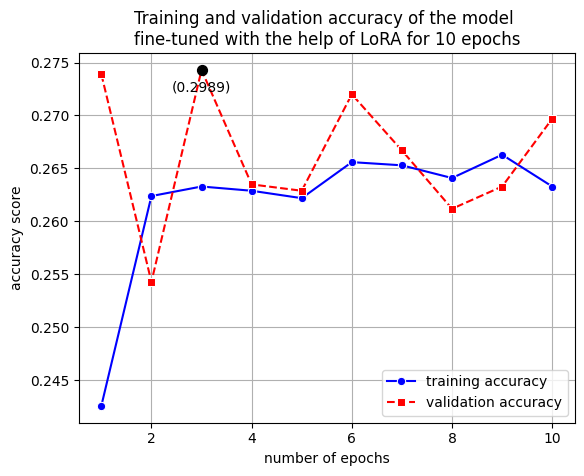

In [64]:
temp_list_lora = list(range(1,11))
data = {
        'X'                    : temp_list_lora,
        'training_accuracy'    : [0.2426, 0.2624, 0.2633, 0.2629, 0.2622, 0.2656, 0.2653, 0.2641, 0.2663, 0.2633],
        'validation_accuracy'  : [0.2739, 0.2543, 0.2743, 0.2635, 0.2629, 0.2720, 0.2667, 0.2612, 0.2633, 0.2697]
}

df_lora = pd.DataFrame(data)


# Create line plot
sns.lineplot(x='X', y='training_accuracy', data=df_lora, marker='o', linestyle='-', color='blue', label='training accuracy')
sns.lineplot(x='X', y='validation_accuracy', data=df_lora, marker='s', linestyle='--', color='red', label='validation accuracy')


# Add labels and title
plt.xlabel('number of epochs')
plt.ylabel('accuracy score')
plt.title('Training and validation accuracy of the model \nfine-tuned with the help of LoRA for 10 epochs')

# Add grid
plt.grid(True)

# Highlight the highest point for validation accuracy
max_y2_lora = df_lora['validation_accuracy'].max()
max_x2_lora = df_lora['X'][df_lora['validation_accuracy'].idxmax()]

plt.scatter(max_x2_lora, max_y2_lora, color='black', s=50, zorder=3)
plt.text(max_x2_lora, max_y2_lora-0.001, f'({max_y2})', color='black', ha='center', va='top')

# Add legend
plt.legend(loc='lower right')

# Save the plot to a file
plt.savefig('images/acc_with_lora.png')

# Show plot
plt.show()


In [65]:
import shutil

# Zipping the the images folder
shutil.make_archive('images', 'zip', '/kaggle/working/images')

'/kaggle/working/images.zip'